In [1]:
import sys
sys.path.append('..')
import numpy as np
from envs.KS_environment import KSenv
from envs.KS_solver import KS
import matplotlib.pyplot as plt

# Defining env
N = 64
actuator_locs = ((2 * np.pi) / 4) * np.arange(4)
sensor_locs = ((2 * np.pi) / N) * np.arange(N)
env = KSenv(nu=0.08,
            actuator_locs=actuator_locs,
            sensor_locs=sensor_locs,
            burn_in=0,
            target='e0')

In [2]:
N_t = 1000

observation_init = env.reset()
observation_arr,_  = observation_init
state_arr = env.u
action_arr = np.zeros(env.action_size)
reward_arr = np.zeros((1,))

for i in range(N_t):
    # action = env.action_space.sample() # random sampling
    action = np.zeros(env.action_size) # no actuation
    # action = np.sin(np.ones(env.action_size)*env.dt*i) # sinusoidal activation

    action_arr = np.vstack((action_arr,action)) # save actions

    observation, reward, terminated, truncated, _ = env.step(action)
    observation_arr = np.vstack((observation_arr,observation)) # save observations
    state_arr = np.vstack((state_arr,env.u)) # save state
    reward_arr = np.vstack((reward_arr,reward)) # save state

    if terminated or truncated:
        observation = env.reset()
        print('Terminated')

Text(0, 0.5, 'Reward')

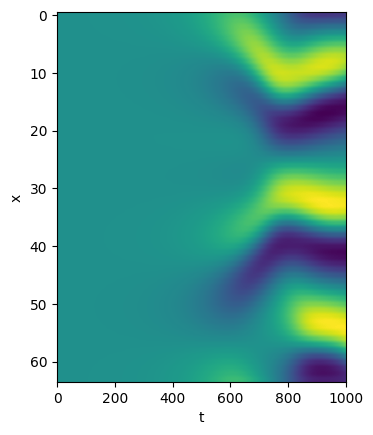

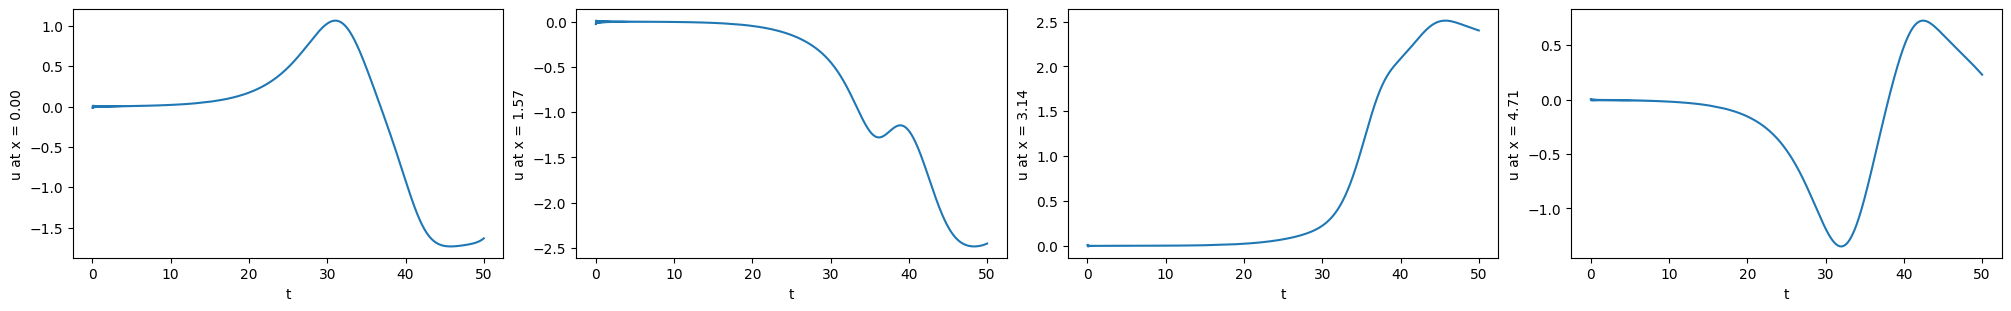

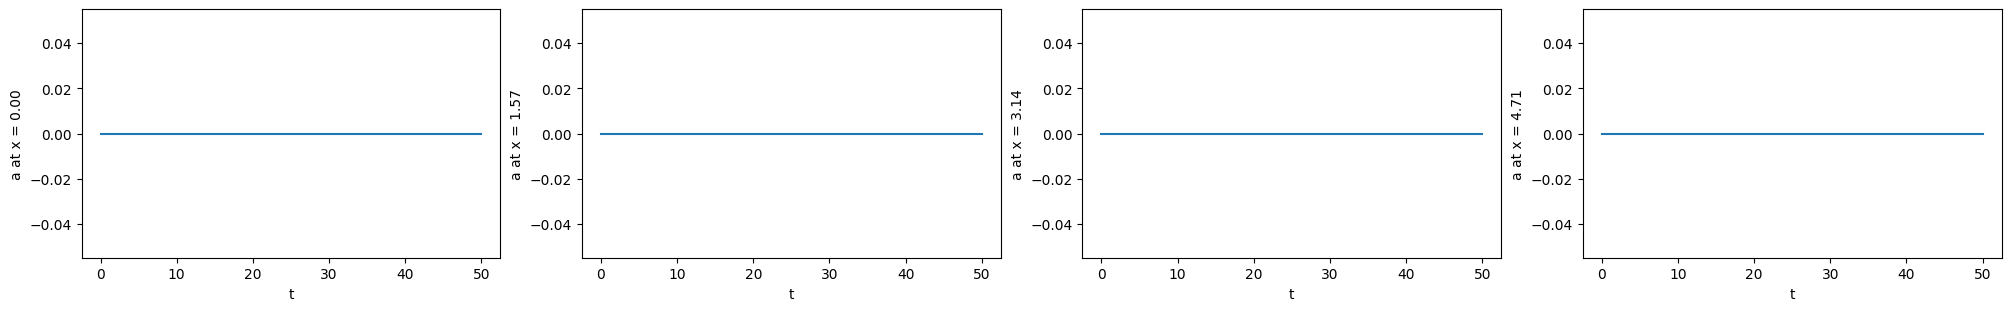

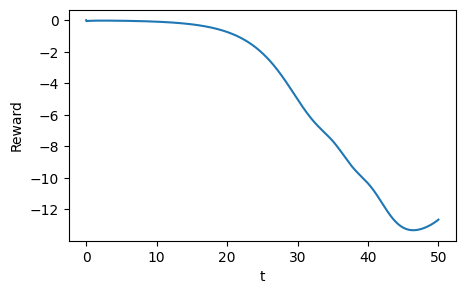

In [19]:
t = env.dt * np.arange(N_t+1)
plt.figure()
plt.imshow(state_arr.T, aspect=20)
plt.xlabel('t')
plt.ylabel('x')

plt.figure(figsize=(20,3),constrained_layout=True)
for sensor_idx, sensor_loc in enumerate(sensor_locs):
    plt.subplot(1,len(sensor_locs),sensor_idx+1)
    plt.plot(t, observation_arr[:,sensor_idx])
    plt.xlabel('t')
    plt.ylabel(f'u at x = {sensor_loc:.2f}')

plt.figure(figsize=(20,3),constrained_layout=True)
for actuator_idx, actuator_loc in enumerate(actuator_locs):
    plt.subplot(1,len(actuator_locs),actuator_idx+1)
    plt.plot(t, action_arr[:,actuator_idx])
    plt.xlabel('t')
    plt.ylabel(f'a at x = {actuator_loc:.2f}')

plt.figure(figsize=(5,3))
plt.plot(t, reward_arr)
plt.xlabel('t')
plt.ylabel('Reward')

# Data assimilation

In [2]:
def advance_f(KS, u, action):
    # just advances the fourier coefficients
    f0 = KS.B @ action
    f = np.fft.rfft(f0, axis=-1)
    u_save = np.copy(u)
    for n in range(3):
        dt = KS.dt / (3 - n)
        # explicit RK3 step for nonlinear term
        u = u_save + dt * KS.nlterm(u, f)
        # implicit trapezoidal adjustment for linear term
        u = (u + 0.5 * KS.lin * dt * u_save) / (1.0 - 0.5 * KS.lin * dt)
    return u

N_high = 64
N_low = 64
dt = 0.05 
nu = 0.08 # the more chaotic system is, we need more modes in the low-order model

actuator_locs = ((2 * np.pi) / 4) * np.arange(4)

my_KS_high = KS(nu=nu,
           N=N_high,
           dt=dt,
           actuator_locs=actuator_locs,
           )
my_KS_low = KS(nu=nu,
           N=N_low,
           dt=dt,
           actuator_locs=actuator_locs,
           )

# Initial data drawn from IID normal distributions
rnd = np.random.RandomState(seed=0)
u0 = rnd.randn(my_KS_high.n)
u0 = 1e-2 * u0

# u0 = np.sin(2*np.pi / my_KS_high.L * my_KS_high.x)

u0 = u0 - u0.mean(axis=-1)
u0_f = np.fft.rfft(u0, axis=-1)
# u0_f = np.fft.fft(u0, axis=-1)
# u0_f = u0_f[:len(my_KS_high.k)]
u0_f_low = my_KS_low.n/my_KS_high.n * u0_f[:len(my_KS_low.k)] # lower order

a0 = np.zeros(len(actuator_locs))
n_t = 2000
u_f = np.zeros((n_t,len(u0_f)), dtype=np.complex128)
u_f[0] = u0_f

u_f_low = np.zeros((n_t,len(u0_f_low)), dtype=np.complex128)
u_f_low[0] = u0_f_low
for i in range(1,n_t):
    a = env.action_space.sample()
    u_f[i] = advance_f(my_KS_high, u_f[i-1], a)
    u_f_low[i] = advance_f(my_KS_low, u_f_low[i-1], a)

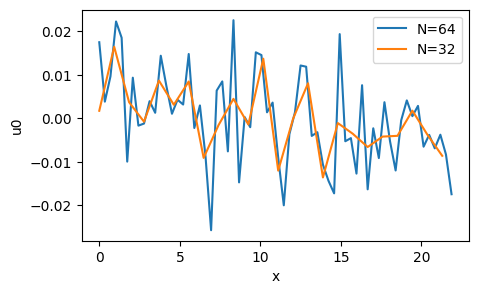

In [55]:
u0_if = np.fft.irfft(u0_f)
u0_if_low = np.fft.irfft(u0_f_low)
plt.figure(figsize=(5,3))
plt.plot(my_KS_high.x, u0_if)
plt.plot(my_KS_low.x, u0_if_low)
plt.xlabel('x')
plt.ylabel('u0')
plt.legend(['N=64','N=32'])

In [56]:
u0_f = np.fft.fft(u0, axis=-1)
k_full = (my_KS_high.n * np.fft.fftfreq(my_KS_high.n)* 2 * np.pi / my_KS_high.L)
x_plot = np.linspace(0,my_KS_high.L,10,endpoint=False)
k_x_full = np.einsum('i,j->ij',x_plot,k_full) * 1j
exp_k_x_full = np.exp(k_x_full)
1/my_KS_high.n * np.real(np.einsum('j,ij->i',u0_f,exp_k_x_full))

array([ 0.01747981,  0.00998345,  0.00012083, -0.01436213, -0.01212341,
       -0.00903858, -0.00023839, -0.00434663,  0.00698304,  0.00029195])

In [57]:
u0_f = np.fft.rfft(u0, axis=-1)
mag = 2/my_KS_high.n * np.abs(u0_f)
phase = np.angle(u0_f)
k_x = np.einsum('i,j->ij',x_plot,my_KS_high.k)
a1 = np.sum(mag * np.cos(k_x + phase), axis = 1)
a2 = 1/my_KS_high.n * np.sum(2*u0_f.real*np.cos(k_x)-2*u0_f.imag*np.sin(k_x), axis=1)

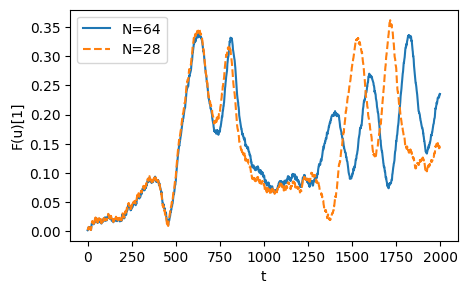

In [66]:
plt.figure(figsize=(5,3))
idx = 1
plt.plot(1/my_KS_high.n * np.abs(u_f[:,idx]))
plt.plot(1/my_KS_low.n * np.abs(u_f_low[:,idx]),'--')
plt.xlabel('t')
plt.ylabel('F(u)[1]')
plt.legend([f'N={my_KS_high.n}',f'N={my_KS_low.n}'])

In [41]:
u = np.fft.irfft(u_f,axis=1)

u_f_low_full = np.hstack((u_f_low,np.conjugate(np.flip(u_f_low[:,1:-1],axis=1))))
k_full = (my_KS_low.n * np.fft.fftfreq(my_KS_low.n)* 2 * np.pi / my_KS_low.L)
x_plot = my_KS_high.x
k_x_full = np.einsum('i,j->ij',x_plot,k_full) * 1j
exp_k_x_full = np.exp(k_x_full)
u_low = 1/my_KS_low.n * np.real(np.einsum('kj,ij->ki',u_f_low_full,exp_k_x_full))

In [23]:
u_init = u[-1].copy()

Text(0, 0.5, 'x')

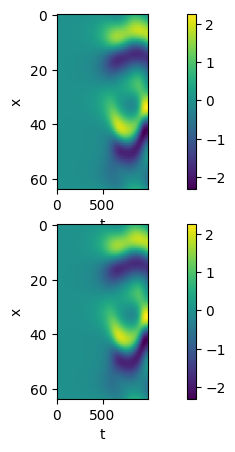

In [42]:
t = dt * np.arange(n_t+1)
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.imshow(u.T, aspect=30)
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')

plt.subplot(2,1,2)
plt.imshow(u_low.T, aspect=30)
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')

In [3]:
from scipy import linalg
rng = np.random.default_rng(5)

def EnKF(Af, d, Cdd, M):
    """ Taken from real-time-bias-aware-DA by Novoa.
        Ensemble Kalman Filter as derived in Evensen (2009) eq. 9.27.
        Inputs:
            Af: forecast ensemble at time t
            d: observation at time t
            Cdd: observation error covariance matrix
            M: matrix mapping from state to observation space
        Returns:
            Aa: analysis ensemble 
    """
    m = np.size(Af, 1)

    psi_f_m = np.mean(Af, 1, keepdims=True)
    Psi_f = Af - psi_f_m

    # Create an ensemble of observations
    if d.ndim == 2 and d.shape[-1] == m:
        D = d
    else: 
        D = rng.multivariate_normal(d, Cdd, m).transpose()
    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = np.real(np.dot(M, Af)) 
    S = np.real(np.dot(M, Psi_f))
    # because we are multiplying with M first, we get real values
    # so we never actually compute the covariance of the complex-valued state
    # if i have to do that, then make sure to do it properly with the complex conjugate!!
    # Matrix to invert
    C = (m - 1) * Cdd + np.dot(S, S.T)
    Cinv = linalg.inv(C)

    X = np.dot(S.T, np.dot(Cinv, (D - Y)))

    Aa = Af + np.dot(Af, X)
    return Aa

# state dimension
Nq = len(my_KS_low.k) 

# observation points
n_sensors = 3
x_obs = np.linspace(0,my_KS_high.L,n_sensors,endpoint=False)

# observation frequency
dt_obs = 0.05

# get the matrices to do inverse dft
k_high = (my_KS_high.n * np.fft.fftfreq(my_KS_high.n)* 2 * np.pi / my_KS_high.L)
k_x_high = np.einsum('i,j->ij',x_obs,k_high) * 1j
exp_k_x_high = np.exp(k_x_high)

k_low = (my_KS_low.n * np.fft.fftfreq(my_KS_low.n)* 2 * np.pi / my_KS_low.L)
k_x_low = np.einsum('i,j->ij',x_obs,k_low) * 1j
exp_k_x_low = np.exp(k_x_low)

# std of observation error
std_obs = 0.2

# initialize
u0 = rng.normal(scale=1e-1,size=my_KS_high.n)
u0 = u0 - u0.mean(axis=-1)
# u0 = u_init
u0_f = np.fft.rfft(u0, axis=-1)
u0_f_low = my_KS_low.n/my_KS_high.n * u0_f[:len(my_KS_low.k)] # lower order

# initialize ensemble
std_init = 0.5
m = 50
Af_0_real = rng.multivariate_normal(u0_f_low.real, np.diag((u0_f_low.real * std_init) ** 2), m).T
Af_0_complex = rng.multivariate_normal(u0_f_low.imag, np.diag((u0_f_low.imag * std_init) ** 2), m).T
Af_0 = Af_0_real + Af_0_complex * 1j

# no actuation
a0 = np.zeros(len(actuator_locs)) 

# store data
n_t = 100
n_first_obs = 100
n_wait = int(np.round(dt_obs/dt))
n_obs = int(np.ceil((n_t-1)/n_wait))

t = np.zeros((n_t+n_first_obs))
t_obs = np.zeros((n_obs))

u_f = np.zeros((n_t+n_first_obs,len(u0_f)), dtype=np.complex128)
u_f[0] = u0_f

u_f_low_wo_KF = np.zeros((n_t+n_first_obs,len(u0_f_low)), dtype=np.complex128)
u_f_low_wo_KF[0] = u0_f_low

# forecast ensemble
Af = np.zeros((n_t+n_first_obs,len(my_KS_low.k),m), dtype=np.complex128)
Af[0] = Af_0

# analysis ensemble
# Aa = np.zeros((n_obs,len(my_KS_low.k),m), dtype=np.complex128)

y_true_mat = np.zeros((n_obs,n_sensors))
y_obs_mat = np.zeros((n_obs,n_sensors))

# forecast until first observation with zero control input
for i in range(n_first_obs):
    t[i+1] = t[i] + dt
    
    # advance simulation with high order model
    u_f[i+1] = advance_f(my_KS_high, u_f[i], a0)

    # advance simulation with high order model
    u_f_low_wo_KF[i+1] = advance_f(my_KS_low, u_f_low_wo_KF[i], a0)

    # advance forecast with low order model
    for m_idx in range(m):
        Af[i+1,:,m_idx] = advance_f(my_KS_low, Af[i,:,m_idx], a0)
j = 0
for i in range(n_first_obs,n_first_obs+n_t-1):
    # get observation
    if (i-n_first_obs) % n_wait == 0:
        t_obs[j] = t[i]
        u_f_full = np.hstack((u_f[i],np.conjugate(np.flip(u_f[i,1:-1]))))
        y_true = np.real(1/my_KS_high.n * exp_k_x_high @ u_f_full) # noise-free! 
        
        # Define observation covariance matrix
        Cdd = np.diag((std_obs * np.ones(len(y_true)))) * np.max(abs(y_true), axis=0) ** 2
        y_obs = rng.multivariate_normal(y_true, Cdd)
        
        y_true_mat[j] = y_true
        y_obs_mat[j] = y_obs
    
        # # apply enkf
        Af_full = np.vstack((Af[i],np.conjugate(np.flip(Af[i,1:-1,:],axis=0))))
        Aa_full = EnKF(Af_full, y_obs, Cdd, 1/my_KS_low.n * exp_k_x_low)

        Aa = Aa_full[:len(my_KS_low.k),:] 
        # correct Af
        Af[i] = Aa

        # # ZERO-ORDER HOLD
        # sample action
        a = env.action_space.sample()
        j = j + 1

    # # sample action
    # a = env.action_space.sample()
    # next step
    t[i+1] = t[i] + dt
    # advance simulation with high order model
    u_f[i+1] = advance_f(my_KS_high, u_f[i], a)
    u_f_low_wo_KF[i+1] = advance_f(my_KS_low, u_f_low_wo_KF[i], a)

    # advance forecast with low order model
    for m_idx in range(m):
        Af[i+1,:,m_idx] = advance_f(my_KS_low, Af[i,:,m_idx], a)

In [12]:
a = np.array([Af[0]])

In [21]:
np.vstack((a,b)).shape

(2, 33, 50)

In [11]:
b = np.array([Af[1]])

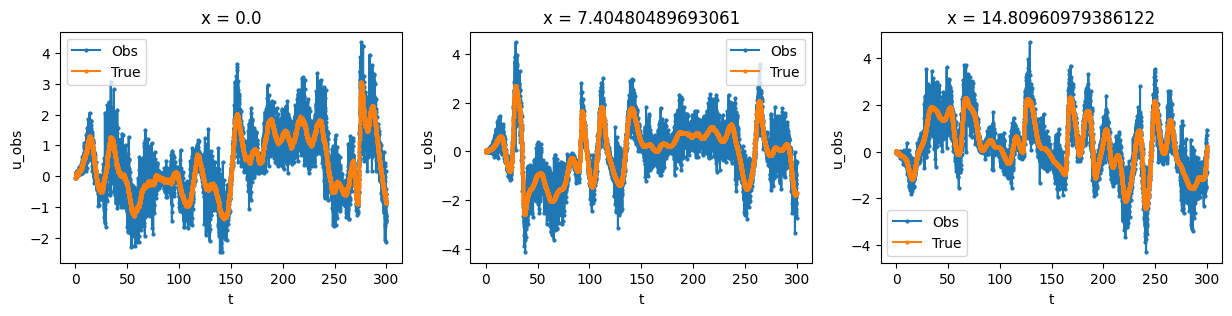

In [86]:
plt.figure(figsize=(15,3))
for i, x in enumerate(x_obs):
    plt.subplot(1,len(x_obs),i+1)
    plt.plot(t_obs,y_obs_mat[:,i], '-o',label='Obs', markersize=2)
    plt.plot(t_obs,y_true_mat[:,i], '-o', label='True', markersize=2)
    plt.xlabel('t')
    plt.ylabel('u_obs')
    plt.title(f'x = {x}')
    plt.legend()
plt.show()

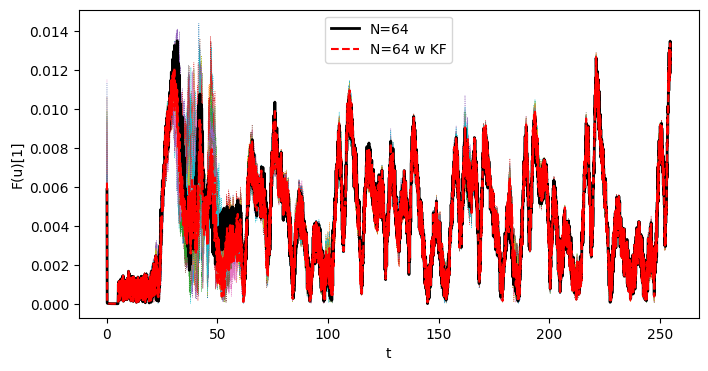

In [190]:
plt.figure(figsize=(8,4))
idx = 9
plt.plot(t,1/my_KS_low.n * np.abs(Af[:,idx,:]),':',linewidth=0.5)
plt.plot(t,1/my_KS_high.n * np.abs(u_f[:,idx]),linewidth=2,color='k',label=f'N={my_KS_high.n}')
plt.plot(t,1/my_KS_low.n * np.abs(np.mean(Af[:,idx,:],axis=-1)),linewidth=1.5,color='red',linestyle='--',label=f'N={my_KS_low.n} w KF')
# plt.plot(t,1/my_KS_low.n * np.abs(u_f_low_wo_KF[:,idx]),'-.',label=f'N={my_KS_low.n} wo KF',color='limegreen')
plt.xlabel('t')
plt.ylabel('F(u)[1]')
plt.legend()
# plt.xlim([0,50])
# plt.ylim([0,0.005])

In [136]:
u = np.fft.irfft(u_f,axis=1)

u_f_low = np.mean(Af, axis=-1)
u_f_low_full = np.hstack((u_f_low,np.conjugate(np.flip(u_f_low[:,1:-1],axis=1))))
k_full = (my_KS_low.n * np.fft.fftfreq(my_KS_low.n)* 2 * np.pi / my_KS_low.L)
x_plot = my_KS_high.x
k_x_full = np.einsum('i,j->ij',x_plot,k_full) * 1j
exp_k_x_full = np.exp(k_x_full)
u_low = 1/my_KS_low.n * np.real(np.einsum('kj,ij->ki',u_f_low_full,exp_k_x_full))

Af_0_full = np.vstack((Af_0,np.conjugate(np.flip(Af_0[1:-1,:],axis=0))))
u0_f_low_full = np.hstack((u0_f_low,np.conjugate(np.flip(u0_f_low[1:-1]))))
u0_low_ens = np.real(1/my_KS_low.n * exp_k_x_full @ Af_0_full)
u0_low_wo_KF = np.real(1/my_KS_low.n * exp_k_x_full @ u0_f_low_full)

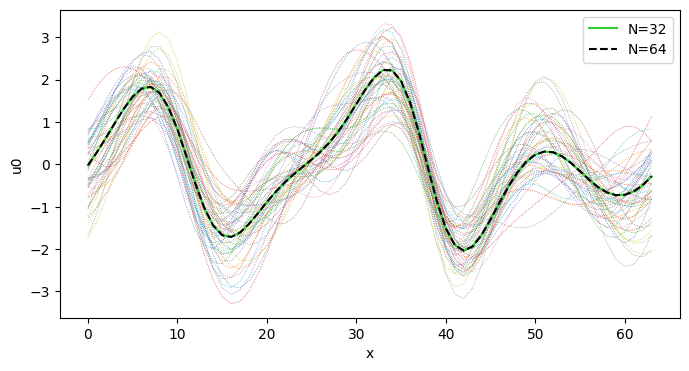

In [137]:
plt.figure(figsize=(8,4))
plt.plot(u0_low_ens,':',linewidth=0.5)
plt.plot(u0_low_wo_KF, color='limegreen', label=f'N={my_KS_low.n}')
plt.plot(u0, color='k', linestyle='--', label=f'N={my_KS_high.n}')
plt.xlabel('x')
plt.ylabel('u0')
plt.legend()
plt.show()

Text(0, 0.5, 'x')

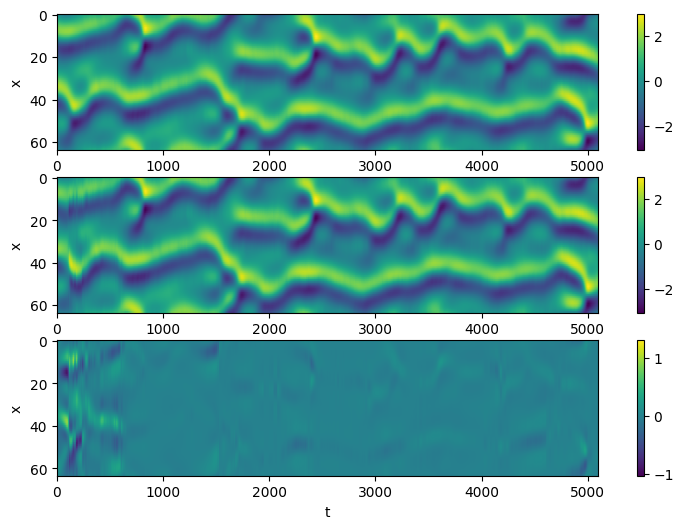

In [138]:
t = dt * np.arange(n_t+1)
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.imshow(u.T, aspect=20)
plt.colorbar()
plt.ylabel('x')

plt.subplot(3,1,2)
plt.imshow(u_low.T, aspect=20)
plt.colorbar()
plt.ylabel('x')

plt.subplot(3,1,3)
plt.imshow(u.T-u_low.T, aspect=20)
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')

In [ ]:
# what are the effects of?
# 1. nu -> more chaotic
# 2. number of modes in the lower/higher order model
# 3. number of sensors
# 4. std of observation
# 5. std of initial condition uncertainty
# 6. sampling rate/analysis update rate 

# it seems like more chaotic, need more modes in the lower order model to be able to track?
# more chaotic means, higher frequency modes have more energy 
# how can we find after what number of modes, the properties are the same? ask Daniel & Elise
# check the fft of higher order model (spatial), check the cut off frequency 
# do we at least need this frequency in our lower order model?
# given some data, how can i determine the minimum number of modes i will need
# does this relate to what andrea did with pod modes

# if we have high level of noise/uncertainty in initial condition and more chaotic system, then need more number of sensors
# above seems irrelevant of lower order model but because of chaos
# less i rely on observation more i must rely on my model vice versa 


# todo:
# 1. check C_dd and initial condition uncertainty. DONE
# size of ensemble > state dimension?
# 2. get some intermediate results to show Luca & others. DONE
# 3. write this code properly in a script so i can run from command line (jax so i can vmap etc)
# 4. run study with varying nu, number of modes, sensors, stds
# 5. add parameter uncertainty

# clean up adjoint-esn repo
# try training esn with adjoint ensemble


In [26]:
import yaml
from pathlib import Path
from gymnasium.wrappers import RecordEpisodeStatistics, TimeLimit
import orbax.checkpoint
from ddpg import DDPG

def load_config(experiment_path):
    with open(experiment_path / "config.yml", "r") as file:
        config = yaml.unsafe_load(file)
        return config

# load config from experiment
experiment_path = Path('../local_results/KS/run_20240825_124452') 
config = load_config(experiment_path)

# create environment
env = KSenv(**config.env)
env = TimeLimit(env, max_episode_steps=config.episode_steps)
env = RecordEpisodeStatistics(env)

# create agent
agent = DDPG(config, env)

# load model weights
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
params_dict = orbax_checkpointer.restore(experiment_path / 'final_model')
params = params_dict["actor"]["target_params"]

In [27]:
def evaluate_KS_for_plotting(env, actor, params, eval_episodes=2):
    # this should go in a different file
    x = np.arange(env.unwrapped.N) * 2 * np.pi / env.unwrapped.N

    fig, axs = plt.subplots(
        eval_episodes,
        3,
        width_ratios=[1, 0.55, 1],
        figsize=(10, 3 * eval_episodes),
        constrained_layout=True,
    )

    for i in range(eval_episodes):
        state, _ = env.reset()
        full_state = env.unwrapped.u

        state_arr = np.array(state)
        full_state_arr = np.array(full_state)
        reward_arr = np.zeros((1,))

        terminated = False
        truncated = False
        while not terminated and not truncated:
            # get action from the target actor network
            action = actor.apply(params, state)
            state, reward, terminated, truncated, info = env.step(action)
            full_state = env.unwrapped.u
            state_arr = np.vstack((state_arr, state))
            full_state_arr = np.vstack((full_state_arr, full_state))
            reward_arr = np.vstack((reward_arr, reward))

        # plot the full state and reward
        im = axs[i, 0].imshow(
            full_state_arr.T,
            extent=[0, len(full_state_arr), x[0], x[-1]],
            origin="lower",
            aspect="auto",
        )
        axs[i, 0].set_xlabel("t")
        axs[i, 0].set_ylabel("x")
        cbar = fig.colorbar(im, ax=[axs[i, 0]], location="left")
        cbar.ax.set_title("u")
        axs[i, 0].set_title(
            f"Return={info['episode']['r'][0]:.2f}, Ave. Reward={info['episode']['r'][0]/info['episode']['l'][0]:.2f}"
        )

        axs[i, 1].plot(env.unwrapped.target, x)
        axs[i, 1].plot(full_state_arr[-1, :], x, "--")
        axs[i, 1].set_yticks(axs[i, 0].get_yticks())
        axs[i, 1].set_yticklabels([])
        axs[i, 1].set_ylim(axs[i, 0].get_ylim())
        axs[i, 1].set_title(f"Last Reward={reward:.2f}")
        axs[i, 1].grid()
        axs[i, 1].set_xlabel("u")
        axs[i, 1].legend(["Target", "Last"])

        err = np.abs(env.unwrapped.target[:, None] - full_state_arr.T)
        im = axs[i, 2].imshow(
            err,
            extent=[0, len(full_state_arr), x[0], x[-1]],
            origin="lower",
            aspect="auto",
            cmap="Reds",
        )
        axs[i, 2].set_xlabel("t")
        axs[i, 2].set_yticks(axs[i, 0].get_yticks())
        axs[i, 2].set_yticklabels([])
        axs[i, 2].set_ylim(axs[i, 0].get_ylim())
        cbar = fig.colorbar(im, ax=[axs[i, 2]], location="right")
        axs[i, 2].set_title("|Target - u|")

    return fig

In [33]:
eval_env_config = {}
for key, val in config.env.items():
    eval_env_config[key] = val

eval_env_config["N"] = 32

In [34]:
# create environment
eval_env = KSenv(**eval_env_config)
eval_env = TimeLimit(eval_env, max_episode_steps=config.episode_steps)
eval_env = RecordEpisodeStatistics(eval_env)

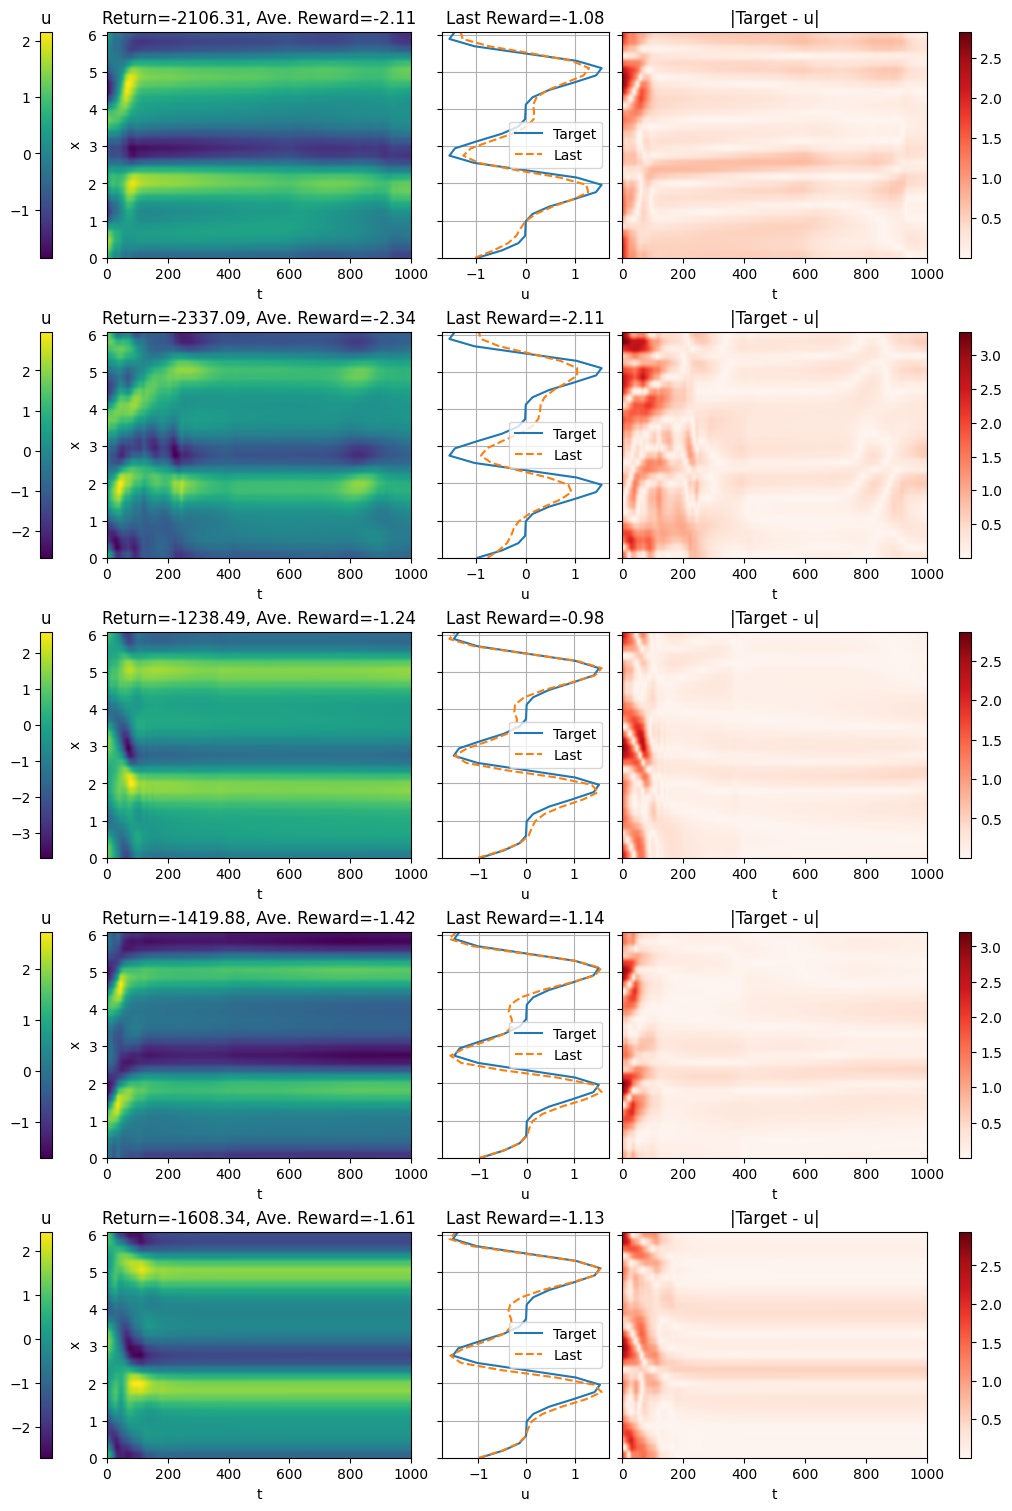

In [35]:
fig = evaluate_KS_for_plotting(eval_env, agent.actor, params, eval_episodes=5)
plt.show()

## jax

In [2]:
from envs.KS_environment_jax import KSenv as KSenv_jax
from envs.KS_solver_jax import KS as KS_jax
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

# Defining env
N = 64
actuator_locs = ((2 * jnp.pi) / 4) * jnp.arange(4)
sensor_locs = ((2 * jnp.pi) / N) * jnp.arange(N)
env_jax = KSenv_jax(nu=0.08,
            actuator_locs=actuator_locs,
            sensor_locs=sensor_locs,
            burn_in=0,
            target='e0')

In [14]:
from functools import partial
reset_fun = partial(KSenv_jax.reset,N=env_jax.N,B=env_jax.ks_solver.B, 
                              lin=env_jax.ks_solver.lin, 
                              ik=env_jax.ks_solver.ik, 
                              dt=env_jax.ks_solver.dt, 
                              initial_amplitude=env_jax.initial_amplitude, 
                              action_size=env_jax.action_size, 
                              burn_in=env_jax.burn_in, 
                              observation_inds=env_jax.observation_inds)
reset_fun = jax.jit(reset_fun)
step_fun = partial(KSenv_jax.step,frame_skip=env_jax.frame_skip,B=env_jax.ks_solver.B, 
                                               lin=env_jax.ks_solver.lin, 
                                               ik=env_jax.ks_solver.ik, 
                                               dt=env_jax.ks_solver.dt, 
                                               target=env_jax.target,  
                                               actuator_loss_weight=env_jax.actuator_loss_weight, 
                                               termination_threshold=env_jax.termination_threshold, 
                                               observation_inds=env_jax.observation_inds)
step_fun = jax.jit(step_fun)
sample_action_fun = partial(KSenv_jax.sample_continuous_space, low=env_jax.action_low, high=env_jax.action_high, shape=(env_jax.action_size,))

In [25]:
N_t = 1000

obs, _ = env.reset()
state0 = env.u
state_arr1 = state0

state2 = jnp.array(state0)
state_arr2 = state2

for i in range(N_t):
    action = env.action_space.sample() # random sampling
    # action = np.zeros(env.action_size) # no actuation

    obs1, reward1, terminated1, truncated1, _ = env.step(action)
    state1 = env.u
    state_arr1 = np.vstack((state_arr1,state1)) # save state

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
state2, obs2, _ = reset_fun(key=key)

def body_fun(carry, _):
    state, key = carry
    action = sample_action_fun(key)
    key, subkey = jax.random.split(key)
    state, obs, reward, terminated, truncated, _ = step_fun(state, action)
    return (state, subkey), state

_, state_arr2 = jax.lax.scan(body_fun,(state2, subkey), np.arange(N_t))

Text(0, 0.5, 'x')

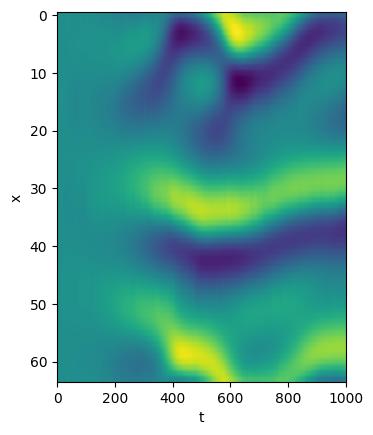

In [26]:
plt.figure()
plt.imshow(state_arr1.T, aspect=20)
plt.xlabel('t')
plt.ylabel('x')

Text(0, 0.5, 'x')

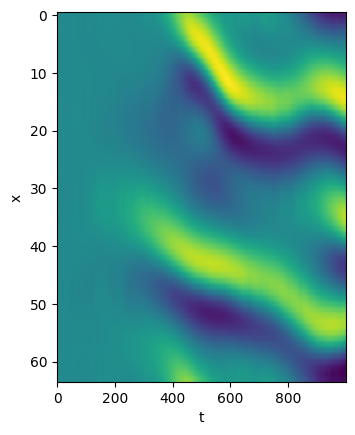

In [27]:
plt.figure()
plt.imshow(state_arr2.T, aspect=20)
plt.xlabel('t')
plt.ylabel('x')